# Food CV Classifier

## Dataset
We will be using the [Food 101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html).

🎯 Goal: Classify ~~101~~ (3, 101 is too much) food.


Most of the training techniques and functions are taken from https://www.learnpytorch.io ,  that includes the pizza, sushi, and steak dataset.

This was my first attempt at Neural Networks.

Why classifying food? I like food. Food also has a variety of colour and shape that comes with it. The background can be different too and lighting changes.

I tried the following model architectures:

- Tiny VGG (mini CNN)
- EfficientNet
- Vision Transformers


# Installation / Setup

In [1]:
# import pytorch & other useful libraries
import os, random
import requests
import zipfile
from tqdm.auto import tqdm # progress bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict

try:
  from torchinfo import summary
except:
  print(f"Importing torchinfo")
  !pip install torchinfo
  from torchinfo import summary

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
writer = SummaryWriter() # keep track of experiments on TensorBoard

Importing torchinfo
torch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126


In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# helper function to make reproducible experiment
def set_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
set_seeds()

# HyperParameters
Change as you need:

In [ ]:
# dataset augmentation
resize_shape = 64 # 224 as well idk
horizontal_flip_prob = 0.5
num_magnitude_bins = 32
# Norm mean and std used from ImageNet
# ImageNet mean and std should be sufficient for this dataset, otherwise we would be computing it from scratch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# dataloader prep
batch_size = 32
num_workers = 0 # os.cpu_count() has to be 0 because we're in Jupyter notebooks (Colab)

# model architecture
hidden_units = 16

# train
epochs = 10
learning_rate = 0.0001

# Dataset

## Preprocessing

1. Import dataset (sushi,steak,pizza) is a subset from Hugging Face's Food 101

2. Split train/test
  - Test split is used to validate model against unseen data to evaluate actual model robustness and accuracy
3. Create Dataloader with Transforms
  - Augment images so model can generalize better when dataset is not sufficient

In [ ]:
# import food101 dataset - only do this is if you have the memory to store everything
# data_path = '/data'
# train_dir = data_path + '/train'
# test_dir = data_path + '/test'
# img_path = Path(data_path)

# train_data = datasets.Food101(root=train_dir,
#                               transform=data_transforms,
#                               split="train",
#                               download=True)

# test_data = datasets.Food101(root=test_dir,
#                              transform=data_transforms,
#                              split="test",
#                              download=True)

# train_data, test_data

In [ ]:
# take subset of training data because otherwise training will take too long

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# Transform pipeline to augment data + less overfitting

data_transforms = transforms.Compose([
    transforms.Resize(size=(resize_shape, resize_shape)),
    transforms.RandomHorizontalFlip(p=horizontal_flip_prob),
    transforms.TrivialAugmentWide(num_magnitude_bins=num_magnitude_bins), # applies random transformation
    # actual transformation magnitude depends on the random transformation picked and magnitude bins
    transforms.ToTensor(),
    # normalize to have stable training (no vanishing/exploding gradients)
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# this is where we add our transforms!
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms)

print(f"Total training images: {len(train_data):,}")
print(f"Total training images: {len(test_data):,}")

image, label = train_data[0]

Total training images: 225
Total training images: 75


In [ ]:
# load our data into dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7937acf34740>,
 <torch.utils.data.dataloader.DataLoader at 0x7937acf35b50>)

In [ ]:
# checking what's inside our dataloader and input output dimensions
for i, batch in enumerate(test_dataloader):
    print(f"Batch {i + 1}, Feature shape: {batch[0].shape}, Label shape: {batch[1].shape}")

print(f"There are {len(test_dataloader)} batches in the test dataloader")

Batch 1, Feature shape: torch.Size([32, 3, 64, 64]), Label shape: torch.Size([32])
Batch 2, Feature shape: torch.Size([32, 3, 64, 64]), Label shape: torch.Size([32])
Batch 3, Feature shape: torch.Size([11, 3, 64, 64]), Label shape: torch.Size([11])
There are 3 batches in the test dataloader


## Data Visualization/Exploration
A model's performance is largely dependent on its input dataset. Therefore, it's important to understand the overall properties of the dataset. Since our datasets are images, we will visualize them in plots.

In [ ]:
def walk_through_dir(dir: str):
  '''Traverses dir and prints # of directories and files in each directory
  '''
  filecount = 0
  for dir_path, dirnames, filenames in os.walk(dir):
    print(f"In {dir_path}, there is {len(dirnames)} directories & {len(filenames)}")
    filecount+=len(filenames)
  print(f"There are {filecount} images in total")
walk_through_dir(data_path)

In data, there is 1 directories & 0
In data/pizza_steak_sushi, there is 2 directories & 0
In data/pizza_steak_sushi/test, there is 3 directories & 0
In data/pizza_steak_sushi/test/pizza, there is 0 directories & 25
In data/pizza_steak_sushi/test/steak, there is 0 directories & 19
In data/pizza_steak_sushi/test/sushi, there is 0 directories & 31
In data/pizza_steak_sushi/train, there is 3 directories & 0
In data/pizza_steak_sushi/train/pizza, there is 0 directories & 78
In data/pizza_steak_sushi/train/steak, there is 0 directories & 75
In data/pizza_steak_sushi/train/sushi, there is 0 directories & 72
There are 300 images in total


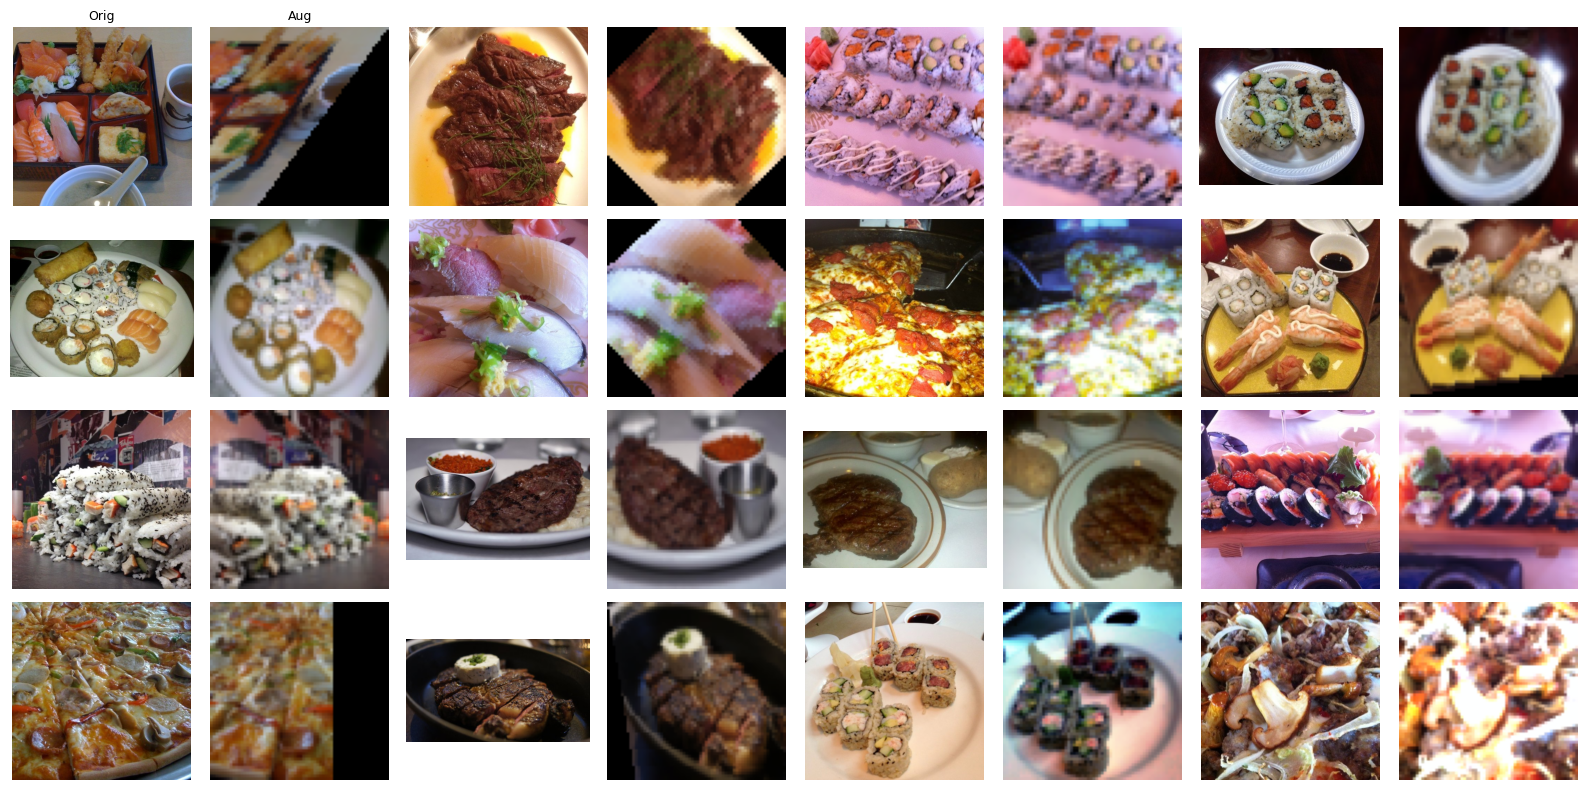

In [ ]:
#img_path = Path(data_path) / 'train' / 'food-101'
img_path = Path(image_path)
# get img list out of img_path
img_list = list(img_path.glob('*/*/*.jpg'))

# sample images
sample_imgs = random.sample(img_list, 16)
# our create a 4x4 grid
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

def denormalize_numpy(img_np, mean, std):
    """
    Denormalize a numpy image
    img_np: shape (H, W, C) with values that have been normalized
    mean: list or array of means for each channel
    std: list or array of stds for each channel
    """
    mean = np.array(mean)
    std = np.array(std)

    # Denormalize: img = img * std + mean
    img_denorm = img_np * std + mean

    # Clip to [0, 1] range to ensure valid image values
    img_denorm = np.clip(img_denorm, 0, 1)

    return img_denorm


for i in range(4):
    for j in range(4):
        idx = i * 4 + j

        # Load original image
        img = Image.open(sample_imgs[idx])

        # Plot original (even columns: 0, 2, 4, 6)
        axes[i, j * 2].imshow(img)
        axes[i, j * 2].axis('off')

        # Apply augmentation and plot (odd columns: 1, 3, 5, 7)
        aug_img = data_transforms(img)
        # Pytorch ToTensor transformations converts imgs to (C,H,W)
        # but Matplotlib takes NumPy imgs with shape (H,W,C)
        aug_img_npy = aug_img.permute(1, 2, 0).numpy()
        # we have to denormalize too to show non-saturated version of the images
        denorm_npy = denormalize_numpy(aug_img_npy,mean=mean,std=std)

        axes[i, j * 2 + 1].imshow(denorm_npy)
        axes[i, j * 2 + 1].axis('off')

# Add column headers
axes[0, 0].set_title('Orig', fontsize=9)
axes[0, 1].set_title('Aug', fontsize=9)

plt.tight_layout()
plt.show()

# Models
Definition of architectures to be used to train our dataset on.

- TinyVGG
  - Small CNN architecture. Let's start simple.
- EfficientNet_B0
- ViT (Vision Transformers)

## TinyVGG
Very small CNN. From https://poloclub.github.io/cnn-explainer/

Basic units:
- Convolution: to aggregate features in a spatial manner
- MaxPool layers: to select most important feature

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    return self.classifier(x)
input_shape = 3 # rgb, number of channels of an image
output_shape = len(train_data.classes)

model_0 = TinyVGG(input_shape, output_shape, hidden_units)
model_0.to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=3, bias=True)
  )
)

In [ ]:
# get a summary of our model
summary(model=model_0,
        input_size=(32, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [32, 3, 64, 64]      [32, 3]              --                   True
├─Sequential (block_1)                   [32, 3, 64, 64]      [32, 16, 32, 32]     --                   True
│    └─Conv2d (0)                        [32, 3, 64, 64]      [32, 16, 64, 64]     448                  True
│    └─ReLU (1)                          [32, 16, 64, 64]     [32, 16, 64, 64]     --                   --
│    └─Conv2d (2)                        [32, 16, 64, 64]     [32, 16, 64, 64]     2,320                True
│    └─ReLU (3)                          [32, 16, 64, 64]     [32, 16, 64, 64]     --                   --
│    └─MaxPool2d (4)                     [32, 16, 64, 64]     [32, 16, 32, 32]     --                   --
├─Sequential (block_2)                   [32, 16, 32, 32]     [32, 16, 16, 16]     --                   True
│    └─Conv2d (0)   

## EfficientNet
This originates from https://arxiv.org/pdf/1905.11946 where it proposes how to efficiently scale CNNs according to depth (how many layers in your neural net), width (number of channels), and resolution (height,width pixels).

We will use its pretrained model for transfer learning to save time on training on large amount of images to get a better performance. To do transfer learning, you freeze the weights of the backbones and add a finetuning layer on top. Note as the `X` in  `EfficientNet_BX` goes up, the model is more complex and memory-heavy and there is a performance-speed tradeoff. Choose according to the resource available and performance needed.

We use `EfficientNet_B0` to start off.

In [ ]:
# Load our EfficientNet_B0 pretrained models with its best weights
from torchvision.models._api import WeightsEnum # to solve error with weights
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 26.1MB/s]


In [ ]:
# get transforms from pre-trained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# freeze feature base layers
for param in model_1.features.parameters():
  param.requires_grad = False

In [ ]:
# change classifier layer to appropriate output shape + target device
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # dropout layer is a regularization technique to prevent overfitting
    nn.Linear(in_features=1280, # look at summary to find in_features
              out_features=output_shape,
              bias=True)
).to(device)

In [ ]:
# Check summary again
summary(model=model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# change our curr dataloader to have correct transforms matching with our pretrained models
train_data_effnet = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data_effnet = datasets.ImageFolder(test_dir, transform=auto_transforms)

train_dataloader_effnet = DataLoader(dataset=train_data_effnet,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
test_dataloader_effnet = DataLoader(dataset=test_data_effnet,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

next(iter(train_dataloader_effnet))[0].shape


torch.Size([32, 3, 224, 224])

## ViT (Vision Transformers)
Takes Transformers to do vision stuff: https://arxiv.org/pdf/2010.11929

Why is Transformers effective for images?
- capture long-range dependencies: can learn relationships with patches in different parts of the img
- scalable: needs less data, model is smaller and simpler

How it works:
1. Each image is broken into Patches PxP and flattened - See PatchEmbedding
2. Positional embedding is added - to add spatial info
3. An extra Learnable (class) embedding (output labels) is added to the sequence of patches
4. The whole is passed passed to TransformerEncoder block
    1. Multiheaded Self-Attention block
    2. MLP block

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # 2D to 1D
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1) # swap channels and flattened last dim

In [ ]:
# MSA
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block part of Transformer architecture
    """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [ ]:
# MLP layer
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block"""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# transformer encoder: series of mla > mlp > mla > mlp > etc.
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [ ]:
# Actual ViT model
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224,
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12,
               embedding_dim: int=768,
               mlp_size: int=3072,
               num_heads: int=12,
               attn_dropout: float=0.1,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1,
               num_classes: int=1000):
    super().__init__()
    assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"
    self.num_patches = int(img_size / patch_size) # this is not accurate
    self.num_patches = 16
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                  num_heads=num_heads,
                                                                  mlp_size=mlp_size,
                                                                  mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
      nn.LayerNorm(normalized_shape=embedding_dim),
      nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    # learnable embedding
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    # equation 1: [x_class, x_p^1,...,x_p^N]+E_pos
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    # equation 3 and 4
    x = self.embedding_dropout(x) # i guess some regularization doesn't hurt
    x = self.transformer_encoder(x)
    # equation 4
    x = self.classifier(x[:, 0])
    return x

In [ ]:
vit = ViT(num_classes=len(train_data.classes))
# summary of ViT model
summary(model=vit,
        input_size=(32, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 64, 64]      [32, 3]              13,824               True
├─PatchEmbedding (patch_embedding)                           [32, 3, 64, 64]      [32, 16, 768]        --                   True
│    └─Conv2d (patcher)                                      [32, 3, 64, 64]      [32, 768, 4, 4]      590,592              True
│    └─Flatten (flatten)                                     [32, 768, 4, 4]      [32, 768, 16]        --                   --
├─Dropout (embedding_dropout)                                [32, 17, 768]        [32, 17, 768]        --                   --
├─Sequential (transformer_encoder)                           [32, 17, 768]        [32, 17, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [32, 17, 768]        [32, 17, 768] 

In [ ]:
# to actually save time we load a pretrained ViT

model_2 = torchvision.models.vit_b_16(pretrained=True)  # ViT-Base/16
# freeze feature base layers
for param in model_2.parameters():
  param.requires_grad = False
# number of heads should correspond to number of classes to finetune
model_2.heads = nn.Linear(model_2.heads.head.in_features, len(train_data.classes))

model_2

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:07<00:00, 48.9MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

# Loss, Optimizer, Accuracy

Cross Entropy is used as a loss function for multi-class classification.

Adam Optimizer is used for optimizing parameters during gradient descent. The optimizer is chosen arbitrarily in this situation though I know Adam converges faster in general. A deeper understanding of this case can help select an optimizer that makes sense.

In [ ]:
# Accuracy = (number of corrects) / (number of guesses)
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 # score out of a 100
    return acc

In [ ]:
# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate)

In [ ]:
# just some test code
train_loss, train_acc = 0, 0

model_1.to(device)
model_1.train()
X, y = next(iter(train_dataloader))
print(f"Batch {X.shape} Label {y.shape}")
X, y = X.to(device), y.to(device)

y_pred = model_1(X)

loss = loss_fn(y_pred, y)


Batch torch.Size([32, 3, 64, 64]) Label torch.Size([32])


# Training

## Helper Methods

In [ ]:
# timer to check training time
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device):
  total_time = end - start
  print(f"Train time on {device}: {total_time} seconds")
  return total_time

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               epoch,
               epochs,
               optimizer: torch.optim,
               device: torch.device=device):
  """Training loop"""
  train_loss, train_acc = 0, 0

  model.to(device)
  model.train()
  # train loop

  for X, y in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
    X, y = X.to(device), y.to(device)
    y_pred = model(X) # forward pass and we get some logits

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += accuracy_fn(y_true=y,y_pred=y_pred_class)

    optimizer.zero_grad() # zero out gradients before we compute them
    loss.backward() # backpropagate gradients
    optimizer.step() # update parameters

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss} | Train Acc: {train_acc}%")
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  """Assess the performance of our model"""
  model.to(device)
  model.eval() # important, we put it on eval mode
  with torch.inference_mode():
    test_loss, test_acc = 0,0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += accuracy_fn(y_true=y,y_pred=test_pred_class)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}%")
    return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          loss_fn: torch.nn.Module,
          acc_fn,
          optimizer: torch.optim,
          epochs: int=10,
          writer = None, # pass tensorboard writer if available
          device: torch.device=device) -> Dict[str, List]:
  """Perform train and validation right after"""
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
  }
  timer_start = timer()

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=acc_fn,
                                        optimizer=optimizer,
                                        epoch=epoch,
                                        epochs=epochs,
                                        device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=acc_fn,
                                    device=device)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    if writer is not None:
      writer.add_scalars(main_tag="Loss",
                        tag_scalar_dict={"train_loss": train_loss,
                                          "test_loss": test_loss},
                        global_step=epoch)
      writer.add_scalars(main_tag="Accuracy",
                        tag_scalar_dict={"train_acc": train_acc,
                                          "test_acc": test_acc},
                        global_step=epoch)
    #writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
  if writer:
    writer.close()
  timer_end = timer()
  total_train_time_model = print_train_time(start=timer_start,
                                                end=timer_end,
                                                device=device)
  return results

## Actual Training

In [ ]:
# train tiny-vgg
model_res = train(model=model_0,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  acc_fn=acc_fn,
                  optimizer=optimizer,
                  writer=writer,
                  epochs=epochs)

model_res

Epoch 1/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0999101102352142 | Train Acc: 28.515625%
Test Loss: 1.1047193606694539 | Train Acc: 20.833333333333332%


Epoch 2/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.091270089149475 | Train Acc: 49.609375%
Test Loss: 1.1168662309646606 | Train Acc: 27.083333333333332%


Epoch 3/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0972710698843002 | Train Acc: 30.46875%
Test Loss: 1.1209871768951416 | Train Acc: 26.041666666666668%


Epoch 4/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0813245177268982 | Train Acc: 42.96875%
Test Loss: 1.1347142855326335 | Train Acc: 26.041666666666668%


Epoch 5/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.1070266962051392 | Train Acc: 31.640625%
Test Loss: 1.1311356623967488 | Train Acc: 27.083333333333332%


Epoch 6/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0958725959062576 | Train Acc: 31.25%
Test Loss: 1.1130210955937703 | Train Acc: 28.125%


Epoch 7/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.089295506477356 | Train Acc: 32.8125%
Test Loss: 1.1162537336349487 | Train Acc: 26.041666666666668%


Epoch 8/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0951549261808395 | Train Acc: 33.203125%
Test Loss: 1.1187020540237427 | Train Acc: 30.208333333333332%


Epoch 9/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0774556547403336 | Train Acc: 53.90625%
Test Loss: 1.1043347120285034 | Train Acc: 26.041666666666668%


Epoch 10/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0722410380840302 | Train Acc: 55.46875%
Test Loss: 1.1146061420440674 | Train Acc: 25.0%
Train time on cpu: 28.57359513700004 seconds


{'train_loss': [1.0999101102352142,
  1.091270089149475,
  1.0972710698843002,
  1.0813245177268982,
  1.1070266962051392,
  1.0958725959062576,
  1.089295506477356,
  1.0951549261808395,
  1.0774556547403336,
  1.0722410380840302],
 'train_acc': [28.515625,
  49.609375,
  30.46875,
  42.96875,
  31.640625,
  31.25,
  32.8125,
  33.203125,
  53.90625,
  55.46875],
 'test_loss': [1.1047193606694539,
  1.1168662309646606,
  1.1209871768951416,
  1.1347142855326335,
  1.1311356623967488,
  1.1130210955937703,
  1.1162537336349487,
  1.1187020540237427,
  1.1043347120285034,
  1.1146061420440674],
 'test_acc': [20.833333333333332,
  27.083333333333332,
  26.041666666666668,
  26.041666666666668,
  27.083333333333332,
  28.125,
  26.041666666666668,
  30.208333333333332,
  26.041666666666668,
  25.0]}

In [ ]:
# EfficientNet_B0
model_res1 = train(model=model_1,
                  loss_fn=loss_fn,
                  train_dataloader=train_dataloader_effnet,
                  test_dataloader=test_dataloader_effnet,
                  acc_fn=acc_fn,
                  optimizer=optimizer,
                  epochs=epochs)

model_res1

Epoch 1/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.100456789135933 | Train Acc: 37.890625%
Test Loss: 1.1375396251678467 | Train Acc: 28.97727272727273%


Epoch 2/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.1004873514175415 | Train Acc: 33.203125%
Test Loss: 1.1227537790934246 | Train Acc: 36.07954545454546%


Epoch 3/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0955513715744019 | Train Acc: 36.328125%
Test Loss: 1.105399529139201 | Train Acc: 33.04924242424242%


Epoch 4/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0816983729600906 | Train Acc: 33.59375%
Test Loss: 1.106248180071513 | Train Acc: 31.060606060606062%


Epoch 5/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0772636830806732 | Train Acc: 33.203125%
Test Loss: 1.094478448232015 | Train Acc: 37.215909090909086%


Epoch 6/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0765794962644577 | Train Acc: 46.09375%
Test Loss: 1.0947035153706868 | Train Acc: 34.090909090909086%


Epoch 7/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0909420996904373 | Train Acc: 33.203125%
Test Loss: 1.099588433901469 | Train Acc: 35.13257575757576%


Epoch 8/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0861672312021255 | Train Acc: 36.328125%
Test Loss: 1.0893819729487102 | Train Acc: 35.13257575757576%


Epoch 9/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0970719456672668 | Train Acc: 34.765625%
Test Loss: 1.0822288195292156 | Train Acc: 37.215909090909086%


Epoch 10/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0756188184022903 | Train Acc: 47.65625%
Test Loss: 1.0800892909367878 | Train Acc: 35.13257575757576%
Train time on cpu: 352.1558410759999 seconds


{'train_loss': [1.100456789135933,
  1.1004873514175415,
  1.0955513715744019,
  1.0816983729600906,
  1.0772636830806732,
  1.0765794962644577,
  1.0909420996904373,
  1.0861672312021255,
  1.0970719456672668,
  1.0756188184022903],
 'train_acc': [37.890625,
  33.203125,
  36.328125,
  33.59375,
  33.203125,
  46.09375,
  33.203125,
  36.328125,
  34.765625,
  47.65625],
 'test_loss': [1.1375396251678467,
  1.1227537790934246,
  1.105399529139201,
  1.106248180071513,
  1.094478448232015,
  1.0947035153706868,
  1.099588433901469,
  1.0893819729487102,
  1.0822288195292156,
  1.0800892909367878],
 'test_acc': [28.97727272727273,
  36.07954545454546,
  33.04924242424242,
  31.060606060606062,
  37.215909090909086,
  34.090909090909086,
  35.13257575757576,
  35.13257575757576,
  37.215909090909086,
  35.13257575757576]}

In [ ]:
data=next(iter(train_dataloader_effnet))[0]
print("train dataloader effnet:",data.shape)

train dataloader effnet: torch.Size([32, 3, 224, 224])


In [ ]:
# VisionTransformer
model_res2 = train(model=model_2,
                  loss_fn=loss_fn,
                  train_dataloader=train_dataloader_effnet,
                  test_dataloader=test_dataloader_effnet,
                  acc_fn=acc_fn,
                  optimizer=optimizer,
                  epochs=epochs)

model_res2

Epoch 1/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.985909067094326 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 2/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.991238072514534 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 3/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9610688984394073 | Train Acc: 64.84375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 4/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9884115681052208 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 5/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0520618557929993 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 6/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0329695641994476 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 7/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.0441301763057709 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 8/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9515439569950104 | Train Acc: 64.84375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 9/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9869446977972984 | Train Acc: 52.734375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%


Epoch 10/10:   0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.9585697427392006 | Train Acc: 64.84375%
Test Loss: 1.0028568704922993 | Train Acc: 57.00757575757576%
Train time on cpu: 2629.068114678 seconds


{'train_loss': [0.985909067094326,
  0.991238072514534,
  0.9610688984394073,
  0.9884115681052208,
  1.0520618557929993,
  1.0329695641994476,
  1.0441301763057709,
  0.9515439569950104,
  0.9869446977972984,
  0.9585697427392006],
 'train_acc': [52.734375,
  52.734375,
  64.84375,
  52.734375,
  52.734375,
  52.734375,
  52.734375,
  64.84375,
  52.734375,
  64.84375],
 'test_loss': [1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993,
  1.0028568704922993],
 'test_acc': [57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576,
  57.00757575757576]}

# Evaluation

Let's see and analyze the performance of our models:

- Print eval metrics
- Plot loss curves
  - Did our model converge properly?
- Plot rand img predictions
- Plot Confusion Matrix
  - Be able to understand True/False Positive/Negative
  - Aim for a diagonal

In [ ]:
# evaluate model
def eval_model(model, dataloader, loss_fn, acc_fn, device):
  model.to(device)
  model.eval()
  with torch.inference_mode():
    loss, acc = 0, 0
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      acc += (y_pred_class == y).sum().item()/len(y_pred)
    loss /= len(dataloader)
    acc /= len(dataloader)
    print(f"Loss: {loss} | Accuracy: {acc}%")
    return { "model_name": model.__class__.__name__,
             "model_loss": loss,
             "model_acc": acc}

In [ ]:
model0_results = eval_model(model_0, test_dataloader, loss_fn, acc_fn, device)
model1_results = eval_model(model_1, test_dataloader, loss_fn, acc_fn, device)
model2_results = eval_model(model_2, test_dataloader_effnet, loss_fn, acc_fn, device)
model0_results, model1_results, model2_results

Loss: 1.1117933988571167 | Accuracy: 0.22916666666666666%
Loss: 1.1082696914672852 | Accuracy: 0.3920454545454546%
Loss: 1.0028568506240845 | Accuracy: 0.5700757575757576%


({'model_name': 'TinyVGG',
  'model_loss': tensor(1.1118),
  'model_acc': 0.22916666666666666},
 {'model_name': 'EfficientNet',
  'model_loss': tensor(1.1083),
  'model_acc': 0.3920454545454546},
 {'model_name': 'VisionTransformer',
  'model_loss': tensor(1.0029),
  'model_acc': 0.5700757575757576})

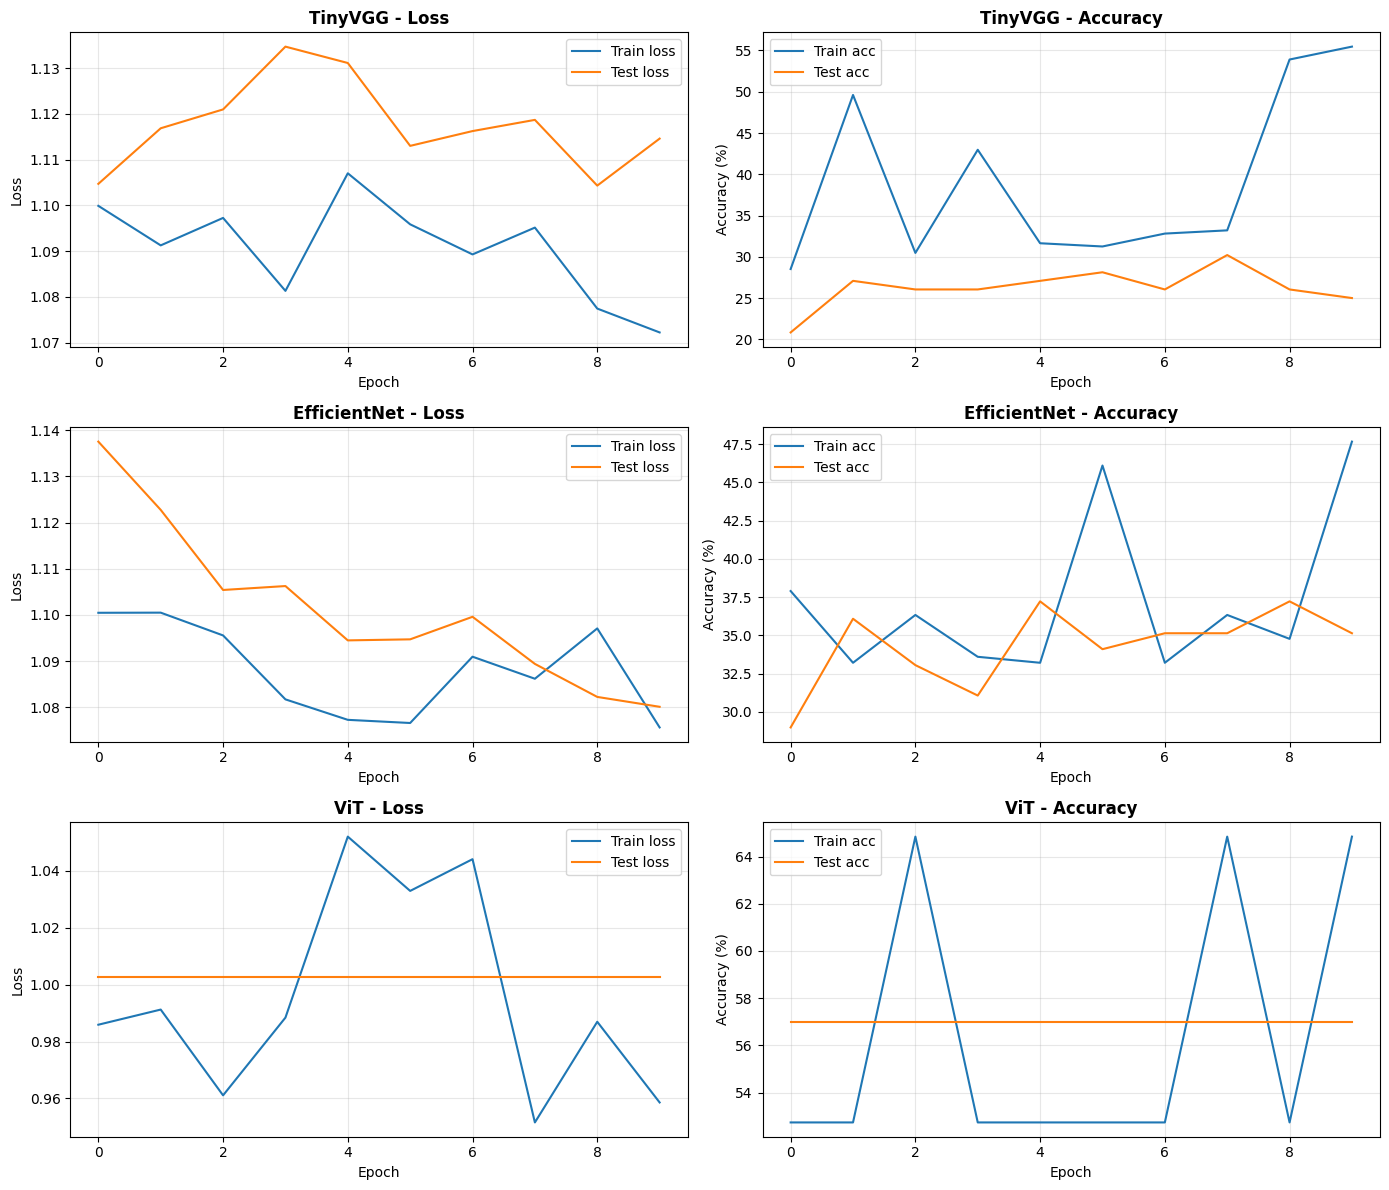

In [ ]:
# plot model loss and accuracy
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
model_names = ["TinyVGG", "EfficientNet", "ViT"]
models = [model_res,model_res1,model_res2]
for i in range(3):
  data = models[i]
  epoch_count = len(data["train_loss"])
  epoch_range = range(epoch_count)
  model_name = model_names[i]

  # plot loss
  axes[i, 0].plot(epoch_range, data["train_loss"], label="Train loss")
  axes[i, 0].plot(epoch_range, data["test_loss"], label="Test loss")
  axes[i, 0].set_title(f"{model_name} - Loss", fontweight='bold')
  axes[i, 0].set_xlabel('Epoch')
  axes[i, 0].set_ylabel('Loss')
  axes[i, 0].grid(True, alpha=0.3)
  axes[i, 0].legend()

  # plot accuracy
  axes[i, 1].plot(epoch_range, data["train_acc"], label="Train acc")
  axes[i, 1].plot(epoch_range, data["test_acc"], label="Test acc")
  axes[i, 1].set_title(f"{model_name} - Accuracy", fontweight='bold')
  axes[i, 1].set_xlabel('Epoch')
  axes[i, 1].set_ylabel('Accuracy (%)')
  axes[i, 1].grid(True, alpha=0.3)
  axes[i, 1].legend()


plt.tight_layout()
plt.show()

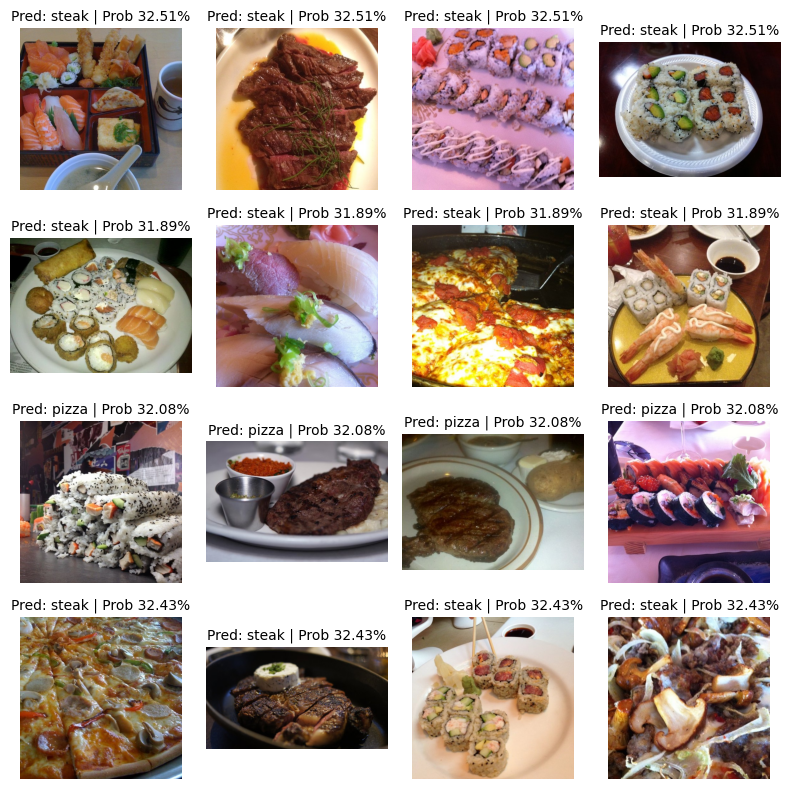

In [ ]:
def pred_and_plot_img(model: nn.Module,
                      imgs: List[str],
                      class_names: List[str],
                      transform= None,
                      img_size: Tuple[int, int] = (224, 224),
                      device: torch.device = device):
  """Predict label for imgs (let's take 16 specifically)"""

  img_labels = []
  img_probs = []
  for img in imgs:
    img = Image.open(img)
    if transform is None:
      transform = transforms.Compose([
          transforms.Resize(img_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=mean,std=std),
      ])
    model.to(device)
    model.eval()
    with torch.inference_mode():
      transf_img = transform(img).unsqueeze(dim=0)
      img_pred = model(transf_img.to(device))
      img_pred_probs = torch.softmax(img_pred, dim=1)
      img_pred_label = torch.argmax(img_pred_probs, dim=1)
      img_labels.append(img_pred_label)
      img_probs.append(img_pred_probs[0][int(img_pred_label[0])-1])

  fig, axes = plt.subplots(4, 4, figsize=(8, 8))
  for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        img = Image.open(imgs[idx])
        prob = float(img_probs[i])*100
        class_name = class_names[img_labels[i]]
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Pred: {class_name} | Prob {prob:.2f}%", fontsize=10)
  plt.tight_layout()
  plt.show()

pred_and_plot_img(model_0, sample_imgs, train_data.classes, data_transforms, (64,64), device)

In [ ]:
# make predictions for bunch of images
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_max = torch.argmax(pred_prob)
            pred_probs.append(pred_max.cpu())

    return torch.stack(pred_probs)

In [ ]:
next(iter(train_dataloader))[1].shape

torch.Size([32])

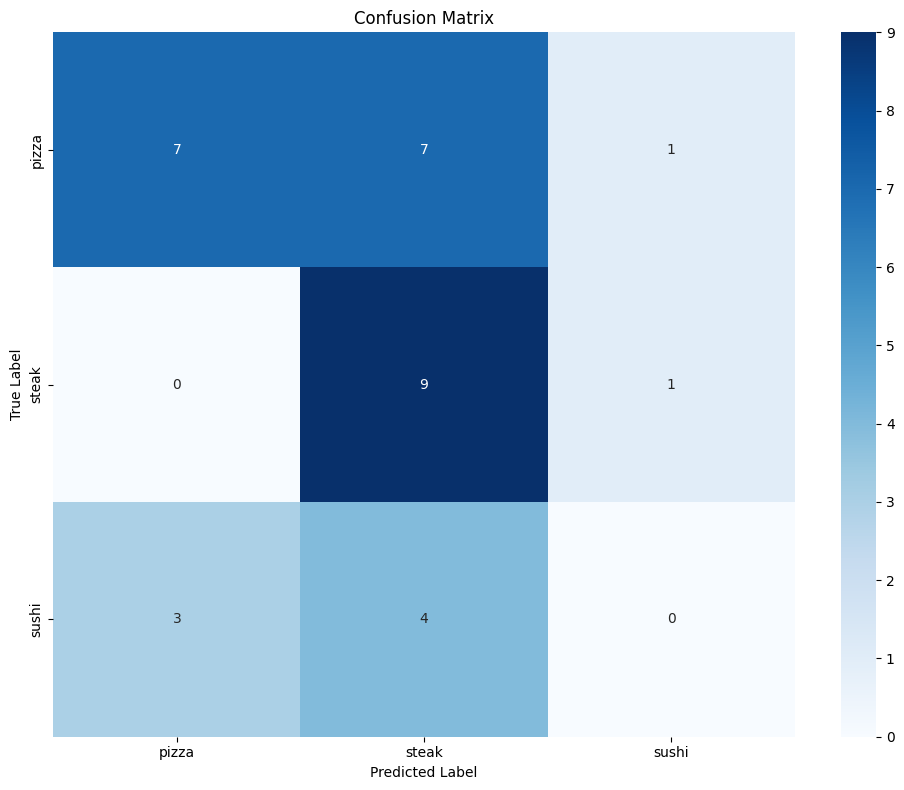

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

X,y_true = next(iter(train_dataloader))
y_pred = make_predictions(model_0,X, device)

cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=train_data.classes,yticklabels=train_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Extra

## Saving Model

In [ ]:
def save_model(model: nn.Module,
               model_name: str,
               model_save_path: str):
  MODEL_PATH = Path(model_save_path)
  MODEL_PATH.mkdir(parents=True,
                  exist_ok=True
  )

  MODEL_NAME = model_name + '.pth'
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  # Save model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
MODEL_SAVE_PATH='/models/food101_model10.pth'
save_model(model_0, "food101_model10", '/models')

## Load Model

In [ ]:
# example of how to load model
loaded_model_2 = TinyVGG(input_shape=1,
                          hidden_units=10,
                          output_shape=len(train_data.classes))

# Load in saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to current device
loaded_model_2 = loaded_model_2.to(device)

## Deploying
Deploy our model using Gradio on Huggingface 🤗

In [ ]:
# import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

In [ ]:
def predict(img, model) -> Tuple[Dict, float]:
  '''Transforms and predict img label and returns time taken to predict

  Arg: img
  '''
  start_time = timer()
  transf_img = data_transforms(img).unsqueeze(dim=0)

  model.eval()
  with torch.inference_mode():
    y_pred_logits = model(transf_img)
    y_pred_probs = torch.softmax(y_pred_logits, dim=1)
    y_pred_label = torch.argmax(y_pred_probs, dim=1)

    pred_time = start_time - timer()
    return model.classes[y_pred_label], pred_time


In [ ]:
import gradio as gr

title = "Food101 Vision"
description = "A computer vision model to classify images of food."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False,
            share=True)

# RECAP

## Basic strategy for finetuning model (hyperparameter discovery) to improve accuracy

- change epochs (training time)
- change # layers / # hidden units
- change amount of data (more data -> more info, but more compute time)
- change learning rate to improve convergence time
- change data augmentation
- choose different model architecture
- experiment with transfer learning
- overfitting?
  - learning rate decay
  - dropout layers
  - regularization

## Some Learnings

- Training a model to classify a significant number of classes is difficult. Ensembling models helps with accuracy. Though it is an interesting challenge (recognizing all kinds of food)

- Understanding why architectures work. ResNet and Transformers work so well due to dynamical isometry

## Next steps

- [ ] A more comprehensive hyperparameter search using a library like Ray.
- [ ] ResNET: another popular framework for image classification.
- [ ] Grad-CAM (feature activation heatmaps) to better understand Convolutional neural network and how it detects/classifies an image as such.